In [15]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from lesson_functions import *

import pickle 
import gc,os

%matplotlib inline


# Example HOG Features

([], <a list of 0 Text yticklabel objects>)

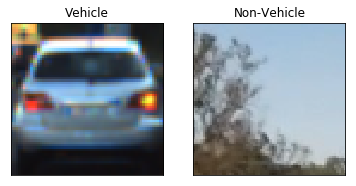

In [2]:
#plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
vehicle = plt.imread('../vehicles/KITTI_extracted/200.png')
plt.imshow(vehicle)
plt.title('Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
non_vehicle = plt.imread('../non-vehicles/extras/extra56.png')
plt.imshow(non_vehicle)
plt.title('Non-Vehicle')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

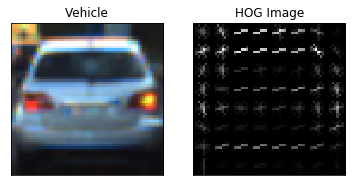

In [3]:
plt.subplot(1,2,1)
plt.imshow(vehicle)
plt.title('Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
features, hog = get_hog_features(vehicle[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
plt.imshow(hog, cmap='gray')
plt.title('HOG Image')
plt.xticks([])
plt.yticks([])

# Image Processing

## Loading Model

In [4]:
## Load model params
with open('svc_params_LUV_hog0_orient9_size32_pix8_cell2.pk', 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data

spatial_feat=True 
hist_feat=True
hog_feat=True

In [5]:
print( color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

LUV 9 8 2 0 (32, 32) 32


## Sliding Windows

In [6]:
img = mpimg.imread('test_images/test6.jpg')

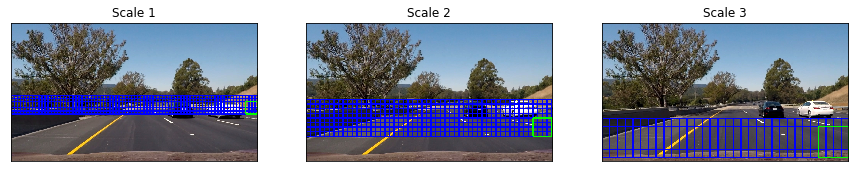

In [7]:
plt.figure(figsize=(15,40))
subpltcount=1

const_list=[(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]

for (ystart, ystop, scale) in const_list:
    plt.subplot(1,3,subpltcount)
    plt.imshow(draw_multi_scale_windows(img, ystart, ystop, scale))
    plt.title('Scale %s'%subpltcount)
    plt.xticks([])
    plt.yticks([])
    subpltcount +=1
    


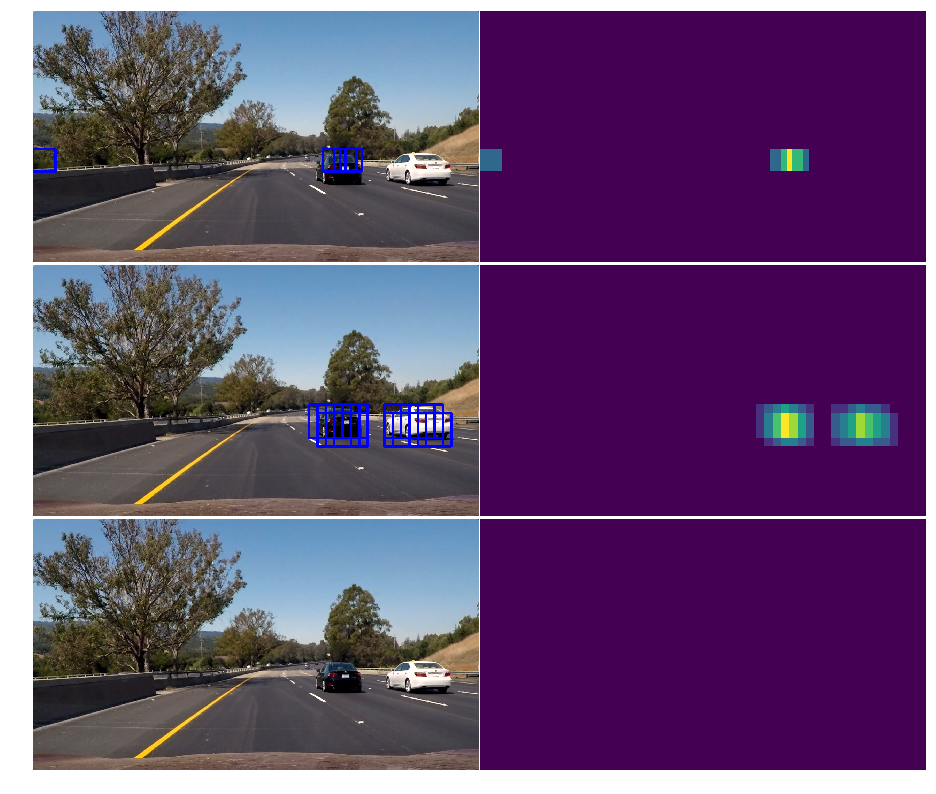

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, (ystart, ystop, scale) in enumerate(const_list):
    out_img,rectangles = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    heatmap=draw_heatmap(img, rectangles, cut=0)
    axs[2*i].imshow(out_img)
    axs[2*i+1].imshow(heatmap)
    axs[2*i].axis('off')
    axs[2*i+1].axis('off')

## Image Processing

In [18]:
def process_image(img, cut=1):

    rectangles = []

    const_list = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
    
    for (ystart, ystop, scale) in const_list:
        rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, 
                                    cell_per_block, hog_channel, spatial_size, hist_bins,vis=False))
        
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)

    heatmap_img = apply_threshold(heatmap_img,cut)
    labels = label(heatmap_img)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img


### No heatmap cut

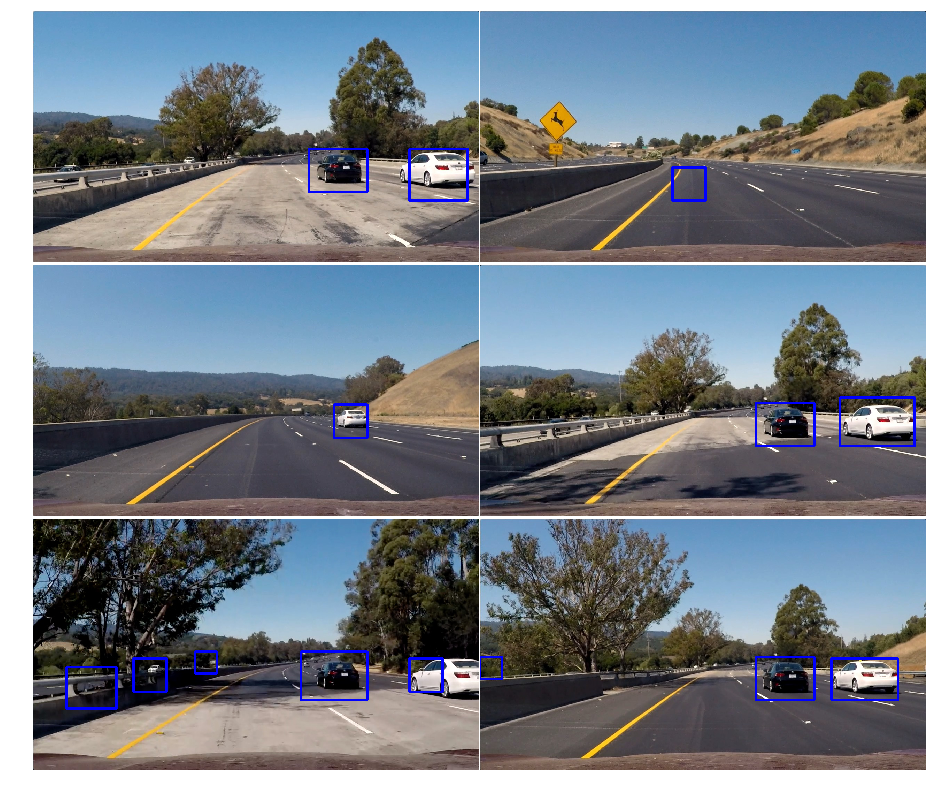

In [31]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(im), cut=0))
    axs[i].axis('off')

### With heatmap cut

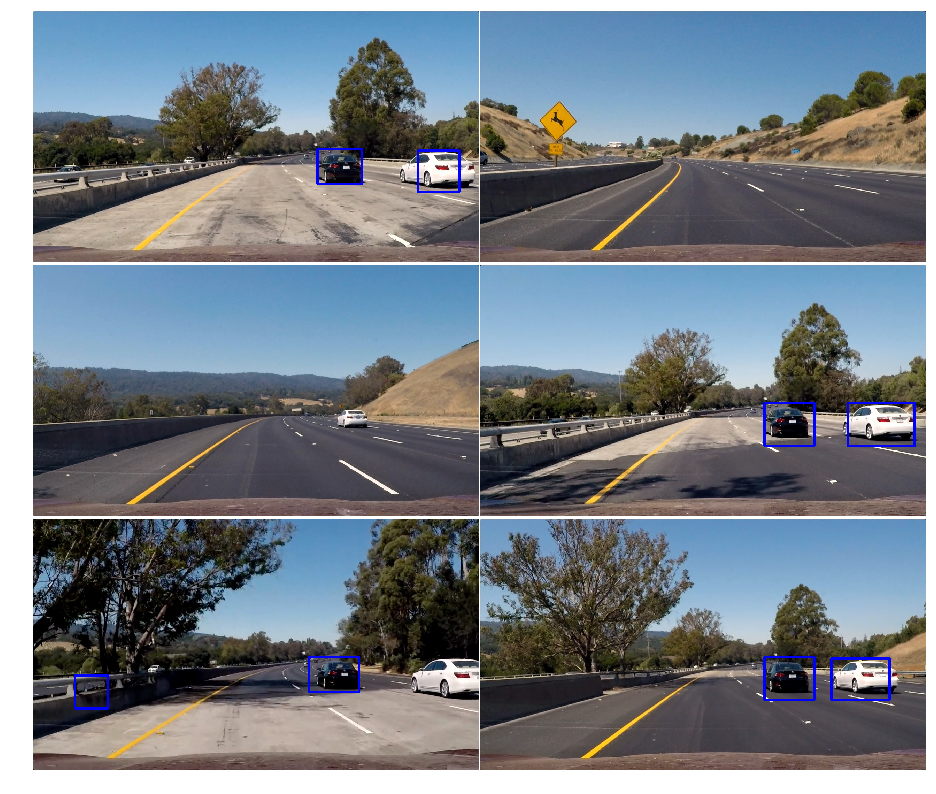

In [32]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(im), cut=1))
    axs[i].axis('off')

# Video Processing

In [27]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = []
        self.prev_heat = []
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 30:
            self.prev_rects = self.prev_rects[len(self.prev_rects)-30:]
    
    def add_heat(self, heat):
        self.prev_heat.append(heat)
        if len(self.prev_heat) > 30:
            self.prev_heat = self.prev_heat[len(self.prev_heat)-30:]


In [25]:
def process_frame_video(img):

    rectangles = []

    const_list = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
    
    for (ystart, ystop, scale) in const_list:
        rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, 
                                    cell_per_block, hog_channel, spatial_size, hist_bins,vis=False))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,rectangles)
        #heat = apply_threshold(heat,1)
        heat[heat>0]=1
        det.add_heat(heat)
    
    heatmap_cut = np.zeros_like(img[:,:,0])
    for heat in det.prev_heat:
        heatmap_cut = heatmap_cut+heat
    
    heatmap_cut = apply_threshold(heatmap_cut, 27)
    heatmap_cut[heatmap_cut>0]=1
    
    heatmap_img = np.zeros_like(img[:,:,0])
    i = 0
    for rect_set in det.prev_rects:
        rect_set_new=check_heat(heatmap_cut,rect_set)
        if len(rect_set_new) > 0:
            i += 1
            heatmap_img = add_heat(heatmap_img, rect_set_new)
    
    heatmap_img = apply_threshold(heatmap_img, i)
   
    # labelling
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    #return draw_img
    return draw_img

In [26]:
det = Vehicle_Detect()

test_out_file = 'test_video_out_luv32.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame_video)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out_luv32.mp4
[MoviePy] Writing video test_video_out_luv32.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_luv32.mp4 

CPU times: user 22.1 s, sys: 146 ms, total: 22.3 s
Wall time: 22.5 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [29]:
det = Vehicle_Detect()

project_out_file = 'project_video_out_luv32.mp4'
clip_project = VideoFileClip('project_video.mp4')
clip_project_out = clip_project.fl_image(process_frame_video)
%time clip_project_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out_luv32.mp4
[MoviePy] Writing video project_video_out_luv32.mp4


100%|█████████▉| 1260/1261 [15:05<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_luv32.mp4 

CPU times: user 15min 24s, sys: 4.07 s, total: 15min 28s
Wall time: 15min 7s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_out_file))